In [5]:
#load in all the A-Z csv files as dataframes and rename the columns to be "definition" and then combine them into one table
import pandas as pd

#load in every file A-Z and rename the columns to be "definition" and then combine them into one table
df = pd.read_csv('A.csv', encoding='latin1')
df.columns = ['definition']
df['letter'] = 'A'
for i in range(1,26):
    letter = chr(i+65)
    df2 = pd.read_csv(letter+'.csv', encoding='latin1')
    df2.columns = ['definition']
    df2['letter'] = letter
    df = pd.concat([df,df2])



In [6]:
#clean the definition column by making lowercase, tokenizing, and removing punctuation and stopwords and removing non english words
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import words
import string
import re

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')
stop_words = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()
english_words = set(words.words())

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]','',text)
    text = word_tokenize(text)
    text = [wordnet_lemmatizer.lemmatize(word) for word in text if word not in stop_words]
    text = [word for word in text if word in english_words]
    return text


df['definition'] = df['definition'].apply(clean_text)


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/samdisorbo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/samdisorbo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/samdisorbo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/samdisorbo/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [7]:
#remove non english words and one letter words
df['definition'] = df['definition'].apply(lambda x: [word for word in x if word in english_words and len(word) > 1])

#remove rows with no words
df = df[df['definition'].map(len) > 1]

#save the cleaned data to a csv
df.to_csv('cleaned_dict.csv', index=False)

#replace commas with spaces
df['definition'] = df['definition'].apply(lambda x: ' '.join(x))

In [8]:
#train a word2vec model on the definitions column
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from gensim.models import FastText
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

#train a word2vec model on the definitions column
sentences = [word_tokenize(x) for x in df['definition']]
model = Word2Vec(sentences,window=10, min_count=1, workers=4)
model.save('codenames.model')



In [26]:
#load the word2vec model
model = Word2Vec.load('codenames.model')

#load the wordlist-eng.txt file as a list of words and turn them to lowercase
wordlist = open('wordlist-eng.txt').read().splitlines()
wordlist = [x.lower() for x in wordlist]

#select 9 random words from the wordlist
import random
random.seed(66)
words = random.sample(wordlist, 9)

#plot those words on a 2d grid using the word2vec model
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

#find the word vectors for the 9 words
vectors = [model.wv[word] for word in words]

#reduce the dimensionality of the word vectors to 2d
pca = PCA(n_components=2)
vectors_2d = pca.fit_transform(vectors)





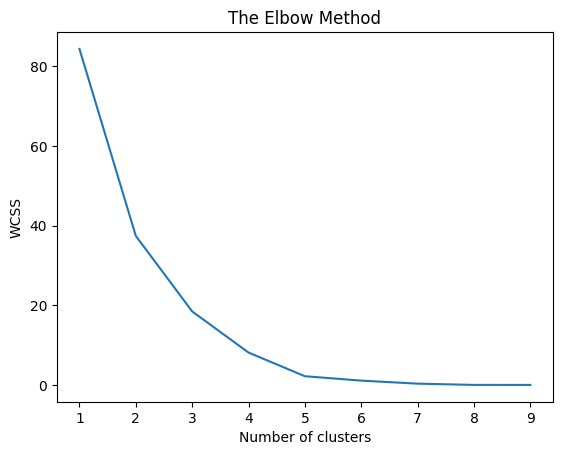

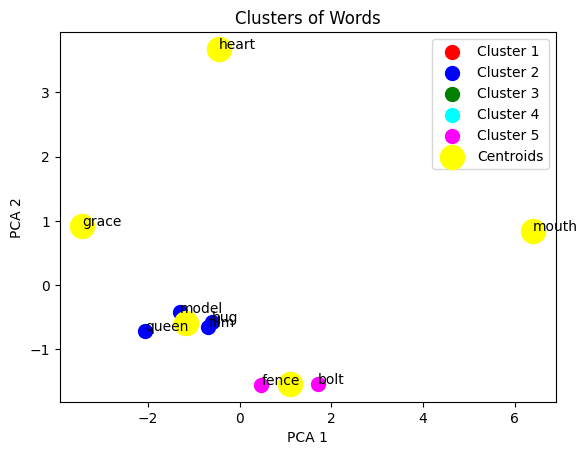

In [27]:

#run k means clustering on the word vectors to find the optiumal number of clusters
from sklearn.cluster import KMeans



wcss = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(vectors_2d)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 10), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

#use the elbow method to find the optimal number of clusters
kmeans = KMeans(n_clusters = 5, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_kmeans = kmeans.fit_predict(vectors_2d)

#plot the words on a 2d grid and color them by their cluster
plt.scatter(vectors_2d[y_kmeans == 0, 0], vectors_2d[y_kmeans == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(vectors_2d[y_kmeans == 1, 0], vectors_2d[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(vectors_2d[y_kmeans == 2, 0], vectors_2d[y_kmeans == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
plt.scatter(vectors_2d[y_kmeans == 3, 0], vectors_2d[y_kmeans == 3, 1], s = 100, c = 'cyan', label = 'Cluster 4')
plt.scatter(vectors_2d[y_kmeans == 4, 0], vectors_2d[y_kmeans == 4, 1], s = 100, c = 'magenta', label = 'Cluster 5')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroids')
for i, word in enumerate(words):
    plt.annotate(word, (vectors_2d[i, 0], vectors_2d[i, 1]))

plt.title('Clusters of Words')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.show()